In [35]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by testing lasso regression 

Compare outputs of feature selections done by lasso regresion, CIT, xgboos

Ridge regression has benefits when dealing with large ds and overfitting might be a problem during model training. 
Ridge regression - in contrast to other models - doesnt directly nullify the inlfuence of less important features - good to determine variables with zero effects

"""
  https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b
key difference however, between Ridge and Lasso regression is that Lasso Regression has the ability to nullify the impact of an irrelevant feature in the data, meaning that it can reduce the coefficient of a feature to zero thus completely eliminating it and hence is better at reducing the variance when the data consists of many insignificant features. Ridge regression, however, can not reduce the coefficients to absolute zero.
Ridge regression performs better when the data consists of features which are sure to be more relevant and useful.

"""

Code idea maily from: https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b

In [36]:
import numpy as np
import pandas as pd

import pickle

from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel


from sklearn.metrics import accuracy_score# , confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score

import matplotlib.pyplot as plt


seed = np.random.seed(11)

import warnings
warnings.filterwarnings('ignore')



In [37]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business_2.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 60)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,...,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,...,1.0,1.0,5,1.0,2.0,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,...,NaN,NaN,5,NaN,3.0,NaN,3.0,NaN,736.5,1.87277


#### Split Data and Normalize variables 
- due that most variables dont have a gaussian distribution, donwside is that distance to outliers is decreased so outliers have influence on the loss calculation (smaller standard deviations when using normaization)


In [38]:
# ## clean df from few nan values

# print(df_candidates.isna().sum())
# df_candidates = df_candidates.dropna()
# print(df_candidates.shape)


# # ## clean df from few nan values
print(df_candidates.isna().sum())
df_candidates = df_candidates.replace(np.nan, 0)


## TODO fix missing values by filling or rmeoving them:
## Idea: remove nan in targets (->get 2 ds) and fill missing values in candidate predictors
## or think about to remove predictors with very many missing values , even they are significant correlated to target eg. warning time



Target_contentloss_euro                         11
Target_businessreduction                        36
inundation_duration_h                            9
water_depth_cm                                   1
contaminations.0                                 0
contaminations.1                                 0
contaminations.2                                 0
contaminations.3                                 0
contaminations.4                                 0
flowvelocity                                     0
warning_time_h                                 308
emergency_measures.1                             0
emergency_measures.2                             0
emergency_measures.3                             0
emergency_measures.4                             0
emergency_measures.6                             0
emergency_measures.7                             0
emergency_measures.8                             0
emergency_measures.9                             0
overall_problem_house          

In [39]:
df_candidates["Target_contentloss_euro"].shape

(397,)

In [40]:
targets = ["Target_contentloss_euro", "Target_businessreduction"]

X_unscaled = df_candidates.drop(targets, axis=1)


In [41]:
# param_dist = {'n_estimators': [10, 100, 200, 500],
#               'max_depth': [1, 3, 5, 10,20],
#               'colsample_bynode': [0.1, 0.3] # nbr of feautres for each split point
#               #'subsample': 0.8  # define subsample of train st, xgb has not bootstrapping
#               }

y_train.shape

(265,)

The goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with SelectFromModel to select the non-zero coefficients. In particular, sparse estimators useful for this purpose are the Lasso for regression

. In particular, the number of samples should be “sufficiently large”, or L1 models will perform at random, where “sufficiently large” depends on the number of non-zero coefficients, the logarithm of the number of features, the amount of noise, the smallest absolute value of non-zero coefficients, and the structure of the design matrix X


In [48]:
## iterate over both targets and store results 

for target in ["Target_contentloss_euro", "Target_businessreduction"]:

    print( f"Apply lasso regression on {target}:\n")
    y = df_candidates[target]

    ## normalize data 
    scaler = MinMaxScaler() 
    X = scaler.fit_transform(pd.DataFrame(X_unscaled))
    y = scaler.fit_transform(pd.DataFrame(y))
    
    ## test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed, shuffle=True)
    X_train = pd.DataFrame(X_train)

    # classes have to start from zero on for lasso regression, make continous variables as categorical 
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

    ## set up model
    #  higher alpha - less features are selected
    lasso_ = Lasso(alpha=0.2)
    lasso_ = SelectFromModel(lasso_) 
    #lasso_ = SelectFromModel(LogisticRegression(C=1, penalty="l1", solver="liblinear", random_state=seed)) 
    lasso_.fit(X_train, y_train) #np.ravel(y_train,order="C"))


    print("Lasso regression:")
    selected_feat = X_train.columns[(lasso_.get_support())]
    not_selected_feat = X_train.columns[~(lasso_.get_support())]

    print("total features: {}".format((X_train.shape[1])))
    print("selected features: {}".format(len(selected_feat)))
    print("dropped features: \n{}\n".format(X_unscaled.columns[not_selected_feat].to_list()))
    ## print("features with coefficients shrank to zero: {}".format(np.sum(lasso_.estimator_.coef_ == 0)))
    #print(f"Selected features: \n{X_unscaled.columns[selected_feat]}")
    #X_train[(ridge_.estimator_.coef_ == 0)#]

    ## store trained model for evaluation
    filename = f'./models_trained/lasso_{target}.sav'
    pickle.dump(lasso_, open(filename, 'wb'))

    ## write selected features to disk
    selected_feat = X_unscaled.columns[selected_feat]
    df_lasso = df_candidates[[target] + selected_feat.to_list()]
    #df_lasso.info()
    df_lasso.to_excel(f"../../input_survey_data/fs_lasso_{target}.xlsx", index=False)


    # ## predict unseen X_test set
    # y_lasso_pred = lasso_.predict(X_test)


Apply lasso regression on Target_contentloss_euro:

Lasso regression:
total features: 58
selected features: 24
dropped features: 
['inundation_duration_h', 'contaminations.0', 'contaminations.1', 'contaminations.2', 'contaminations.3', 'warning_time_h', 'emergency_measures.1', 'emergency_measures.3', 'emergency_measures.4', 'emergency_measures.6', 'emergency_measures.8', 'contaminations_visible', 'resistant_material_building_impl', 'electricity_higher_impl', 'flood_protections_impl', 'elevation_building_height_cm', 'bage', 'b_area', 'hh_monthly_income_cat', 'shp_owner', 'shp_sector', 'shp_employees', 'shp_suppliers_location.4', 'shp_suppliers_location.5', 'shp_profits_last5years', 'shp_risk_tolerance', 'shp_monetary_resources4prevention', 'resilience_city_protection', 'resilience_left_alone', 'resilience_neighbor_management', 'perception_who_responsible4protection.Rank1', 'perception_govern_support_future', 'shp_content_value_euro', 'shp_registered_capital_euro']

Apply lasso regressio

### Evaluation

In [50]:
## reload models

print(targets)
target = targets[0]
lasso_model = pickle.load(open(f"./models_trained/lasso_{target}.sav", 'rb'))

#result = lasso_model.score(X_test, y_test)
#lasso_model
lasso_model.get_params()

['Target_contentloss_euro', 'Target_businessreduction']


{'estimator__alpha': 0.2,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': 1000,
 'estimator__positive': False,
 'estimator__precompute': False,
 'estimator__random_state': None,
 'estimator__selection': 'cyclic',
 'estimator__tol': 0.0001,
 'estimator__warm_start': False,
 'estimator': Lasso(alpha=0.2),
 'importance_getter': 'auto',
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': None}

#### Feature importance

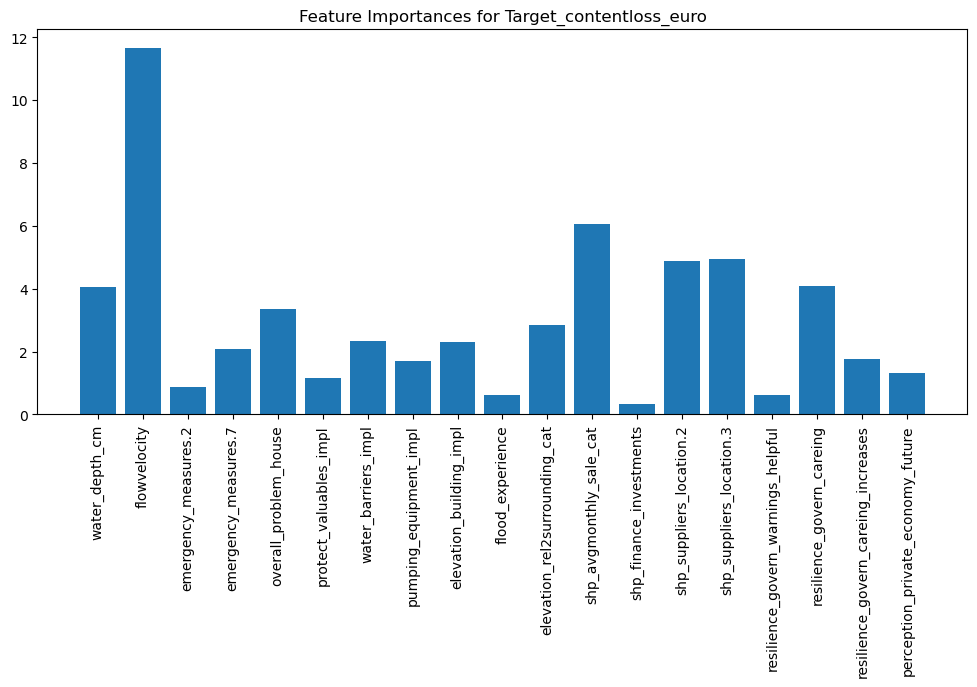

In [55]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,5))

## coef of feature importances
importance = lasso_model.estimator_.coef_[0]

df_importance = pd.DataFrame({
    "name" : X_unscaled.columns.to_list(),
    "importances" : lasso_model.estimator_.coef_,
     }) 

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0.0, : ] 

plt.bar(df_importance.name, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

In [58]:
# # define the model evaluation by k-fold CV
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate the model and collect the scores
# n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [364]:
# removed_feats = X_train.columns[(lasso_.estimator_.coef_ == 0).ravel().tolist()]
# removed_feats

# X_train_selected = lasso_.transform(X_train)
# X_test_selected = lasso_.transform(X_test)
# X_train_selected.shape, X_test_selected.shape